In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
import pandas as pd

data = pd.read_excel('data_readed.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values('datetime', inplace=True)
print(data.columns)


Index(['row', 'col', 'datetime', 'AWS', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR',
       'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW',
       'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850'],
      dtype='object')


In [ ]:
features = ['AWS', 'CAPE', 'CIN', 'V850', 'KX', 'R250', 'R500', 'U250', 'U850', 'EWSS']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features].values)
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(data[['AWS']].values)
input_steps = 6
forecast_steps = 6
X_seq = []
y_seq = []
for i in range(len(data) - input_steps - forecast_steps + 1):
    X_seq.append(X_scaled[i : i + input_steps])
    y_seq.append(y_scaled[i + input_steps : i + input_steps + forecast_steps, 0])
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_seq = y_seq.reshape((y_seq.shape[0], y_seq.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print('train size:', X_train.shape, y_train.shape)
print('test size:', X_test.shape, y_test.shape)


train size: (526136, 6, 10) (526136, 6, 1)
test size: (131534, 6, 10) (131534, 6, 1)


In [7]:
from tensorflow.keras.layers import TimeDistributed

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 64)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 6, 1)           │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stop])


Epoch 1/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.9240 - val_loss: 0.9361
Epoch 2/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8947 - val_loss: 0.9307
Epoch 3/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8915 - val_loss: 0.9280
Epoch 4/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.8815 - val_loss: 0.9266
Epoch 5/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.9087 - val_loss: 0.9261
Epoch 6/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8825 - val_loss: 0.9251
Epoch 7/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8945 - val_loss: 0.9229
Epoch 8/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.8982 - val_loss: 0.9229
Epoch 9/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8889 - val_loss: 0.9211
Epoch 10/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8942 - val_loss: 0.9191
Epoch 11/50
6577/6577 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.8823 - val_loss: 0.9189
Epoch 12/50
6577/65

4111/4111 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


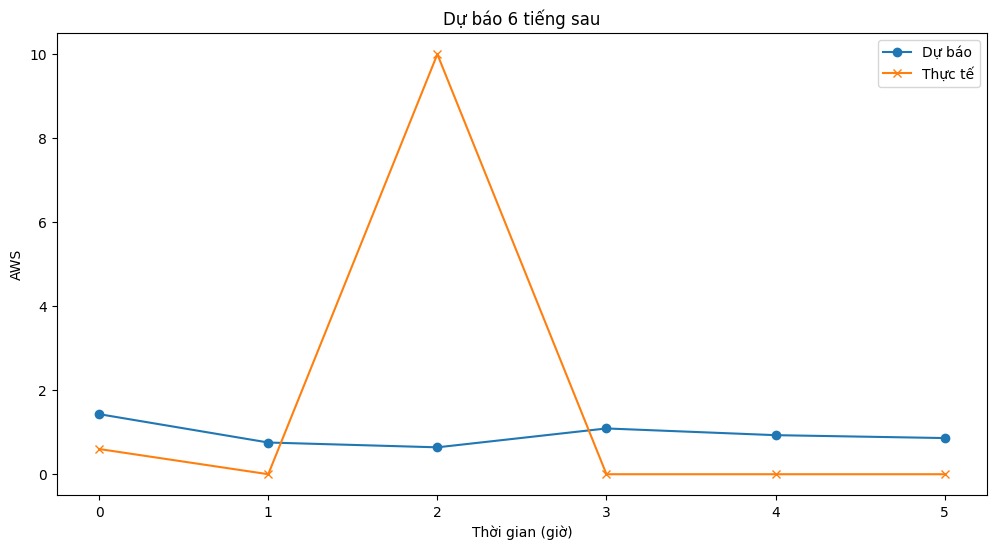

In [12]:
pred_scaled = model.predict(X_test)
pred_inv = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).reshape(pred_scaled.shape)
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(pred_inv[0,:,0], marker='o', label='Dự báo')
plt.plot(y_test_inv[0,:,0], marker='x', label='Thực tế')
plt.title("Dự báo 6 tiếng sau")
plt.xlabel("Thời gian (giờ)")
plt.ylabel("AWS")
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inv.flatten(), pred_inv.flatten())
print("MSE:", mse)


MSE: 4.696807515069374


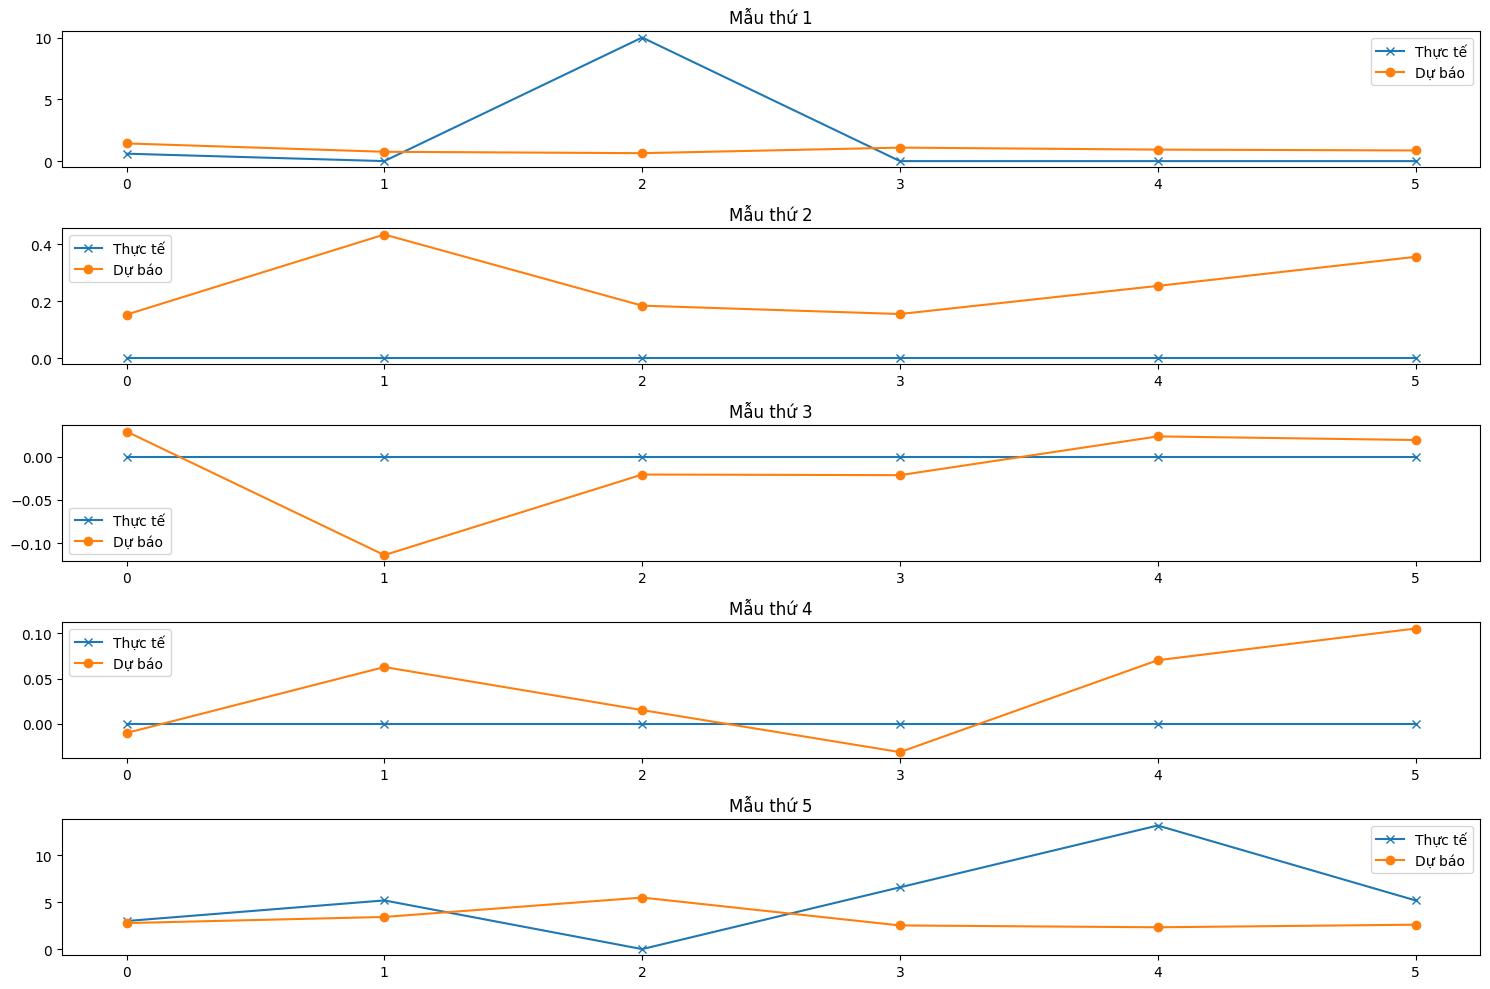

In [ ]:
num_samples = 5
plt.figure(figsize=(15,10))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(y_test_inv[i,:,0], marker='x', label='Thực tế')
    plt.plot(pred_inv[i,:,0], marker='o', label='Dự báo')
    plt.title(f'Mẫu thứ {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()
